# 查询，键，值

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

可视化查询和键之间的注意力权重

In [10]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                 cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                               sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_xlabel(ylabel)
            if titles:
                ax.set_title(titles[i])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

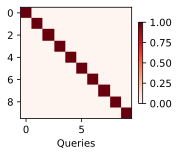

In [11]:
attention_weights = torch.eye(10).reshape(1, 1, 10, 10)
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')


# 注意力汇聚：Nadaraya-Watson回归

In [12]:
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
n_train = 50
x_train, _ =  torch.sort(torch.rand(n_train) * 5)

In [15]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [24]:
# 绘制所有耳朵训练样本
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y',
            legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

平均汇聚

In [25]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)

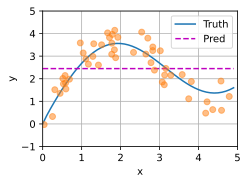

In [26]:
plot_kernel_reg(y_hat)

非参数注意力汇聚，根据输入的位置对输出进行加权

In [28]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

In [32]:
X_repeat

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])

In [35]:
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

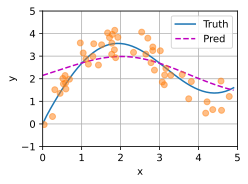

In [48]:
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

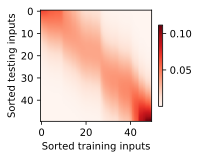

In [51]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel="Sorted training inputs",
                 ylabel='Sorted testing inputs')

带参数注意力汇聚，查询x和键x_i之间的距离乘以可学习的参数w

定义带参数的核回归模型

In [98]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1,), requires_grad=True)
    
    def forward(self, queries, keys, values):
        # queries 和 attention_weights 的形状为（查询个数，“键-值”对个数）
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -(((queries - keys) * self.w) ** 2 / 2), dim=1)\
        # values 的形状为（查询个数， “键-值”对个数）
        return torch.bmm(self.attention_weights.unsqueeze(1), 
                        values.unsqueeze(-1)).reshape(-1)

训练模型

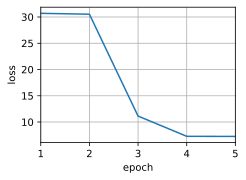

In [100]:
X_title = x_train.repeat((n_train, 1))  # 每一行都包含着相同的训练输入
Y_title = y_train.repeat((n_train, 1))  # 每一行都包含着相同的训练输出
keys = X_title[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_title[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

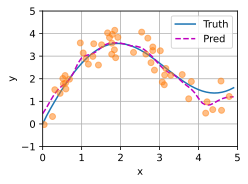

In [108]:
# 预测结果绘制图
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)


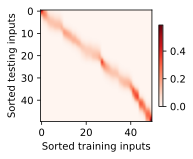

In [109]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs',
                 ylabel='Sorted testing inputs')

# 注意力评分函数

1. 遮蔽softmax操作
2. 加性注意力
3. 缩放点积注意力

遮蔽softmax操作

In [124]:
# 将超出有效长度的位置被遮蔽掉并置为0
def masked_softmax(X, valid_lens=None):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作"""
    # X :3D张量，valis_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
            print(valid_lens)
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                             value=-1e6)
        print(X)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [120]:
# 2*4 矩阵表示样本，两个样本的有效长度分别是2和3
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([2, 2, 3, 3])
tensor([[ 2.9883e-01,  8.7254e-01, -1.0000e+06, -1.0000e+06],
        [ 6.7834e-01,  9.2220e-01, -1.0000e+06, -1.0000e+06],
        [ 3.9042e-01,  3.8015e-01,  5.1761e-01, -1.0000e+06],
        [ 5.5558e-01,  6.3913e-01,  7.0129e-01, -1.0000e+06]])


tensor([[[0.3604, 0.6396, 0.0000, 0.0000],
         [0.4393, 0.5607, 0.0000, 0.0000]],

        [[0.3200, 0.3167, 0.3634, 0.0000],
         [0.3083, 0.3351, 0.3566, 0.0000]]])

In [122]:
# 使用二维张量为矩阵样本中的每一行指定有效长度
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 2],
                                                 [3, 4]]))

tensor([[ 5.9505e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [ 4.7045e-01,  6.9875e-01, -1.0000e+06, -1.0000e+06],
        [ 1.8357e-01,  2.7962e-01,  8.5523e-01, -1.0000e+06],
        [ 4.5048e-01,  1.5484e-01,  7.9375e-01,  7.5382e-01]])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4432, 0.5568, 0.0000, 0.0000]],

        [[0.2464, 0.2713, 0.4823, 0.0000],
         [0.2218, 0.1651, 0.3127, 0.3004]]])

加性注意力

In [173]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AddtiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
#         print(f'queries.shape:{queries.shape}')
#         print(f'keys.shape:{keys.shape}')
        # 在维度扩展后，
        # queries 的形状为(batch_size, 查询个数，1， num_hiddens)
        # key 的形状为(batch_size, 1, 键-值对的个数， num_hiddens)
        # 使用广播方式进行求和
        featrues = queries.unsqueeze(2) + keys.unsqueeze(1)
#         print(f'featrues.shape:{featrues.shape}')
        featrues = torch.tanh(featrues)
        # self.w_v 仅有一个输出，因此从形状中移除最后那个维度
        # scores 的形状为(batch_size, 查询个数， 键-值对的个数)
        scores = self.w_v(featrues).squeeze(-1)
#         print(f'scores.shape:{scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values 的形状(batch_size, 键-值对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)
    

In [142]:
# 演示上面的AddtiveAttention类
# 查询、键、值的形状为(批量大小，步数或词元的长度，特征大小)
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AddtiveAttention(key_size=2, query_size=20, num_hiddens=8,
                            dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

queries.shape:torch.Size([2, 1, 8])
keys.shape:torch.Size([2, 10, 8])
featrues.shape:torch.Size([2, 1, 10, 8])
scores.shape:torch.Size([2, 1, 10])
tensor([2, 6])
tensor([[ 7.0749e-01,  7.0749e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06,
         -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [ 6.4878e-01,  6.4878e-01,  6.4878e-01,  6.4878e-01,  6.4878e-01,
          6.4878e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06]],
       grad_fn=<AsStridedBackward>)


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

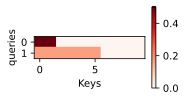

In [147]:
# 绘制注意力权重热图
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                 xlabel='Keys', ylabel='queries')

缩放点积注意力

In [154]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # queries 的形状为(batch_size, 查询个数， d)
    # keys 的形状为(batch_size, 键-值 对的个数， d)
    # values 的形状为(batch_size, 键-值 对的个数，值的维度)
    # valid_lens 的形状 (batch_size) 或者(batch_size, 查询个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights= masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [155]:
# 演示上面的DotProductAttention类
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)


tensor([2, 6])
tensor([[ 2.2230e+00,  2.2230e+00, -1.0000e+06, -1.0000e+06, -1.0000e+06,
         -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [-1.8660e+00, -1.8660e+00, -1.8660e+00, -1.8660e+00, -1.8660e+00,
         -1.8660e+00, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06]])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

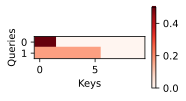

In [156]:
# 绘制点积缩放注意力权重热图
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                 xlabel='Keys', ylabel='Queries')


# Bahanau注意力

- 查询：时间步t'-1 时的解码器隐藏状态。
- 键、值：编码器隐藏状态$h_t$
- 注意力权重$\alpha$：加性注意力打分函数

In [157]:
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [8]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    """带有Bahdanau注意力的解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_output, enc_valid_lens, *args):
        # outputs 的形状为(batch_size, num_steps, num_hiddens)
        # hidden_state 的形状为(num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_output
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        # X 输出的形状为(num_steps, batch_size, num_hiddens)
        X = self.embedding(X).permute((1, 0, 2))
        outputs, self._attention_weights = [], []
        for x in X:
            # query 的形状为(batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # 加性注意力
            # contect 的形状为(batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连接
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # x 变形为(1, batch_size, embed_size + num_hidden)
            out, hidden_state = self.rnn(x.permute((1, 0, 2)), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为(num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [180]:
# 演示
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                            num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                 num_layers=2)
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 7907.2 tokens/sec on cuda:0


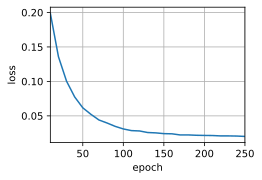

In [10]:
# 训练机器翻译
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 62, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                            num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                     num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [15]:
# 演示预测示例
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}',
         f'bleu{d2l.bleu(translation, fra, k=2):.3f}')

go . => va ! bleu1.000
i lost . => j'ai perdu . bleu1.000
he's calm . => je suis <unk> . bleu0.000
i'm home . => je suis chez moi . bleu1.000


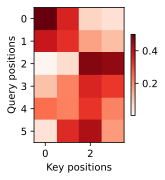

In [16]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq],
                             0).reshape((1, 1, -1, num_steps))
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

# 多头注意力